ДЗ 2

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

Формируем тренировочный датасет.

In [35]:
x_min = 0
x_max = 5
points = 1000

X_train = np.linspace(x_min, x_max, points + 1)
y_train = f(X_train)

In [37]:
def func_targ(X, w_coeff):
    Y = np.zeros_like(X)
    for n, x in enumerate(X):
        for idx, w in enumerate(w_coeff.tolist()[0]):
            Y[n] = Y[n] + w * x**idx
    return Y

def loss_func(X, y, w_coeff):
    return np.sum((y - func_targ(X, w_coeff))**2)

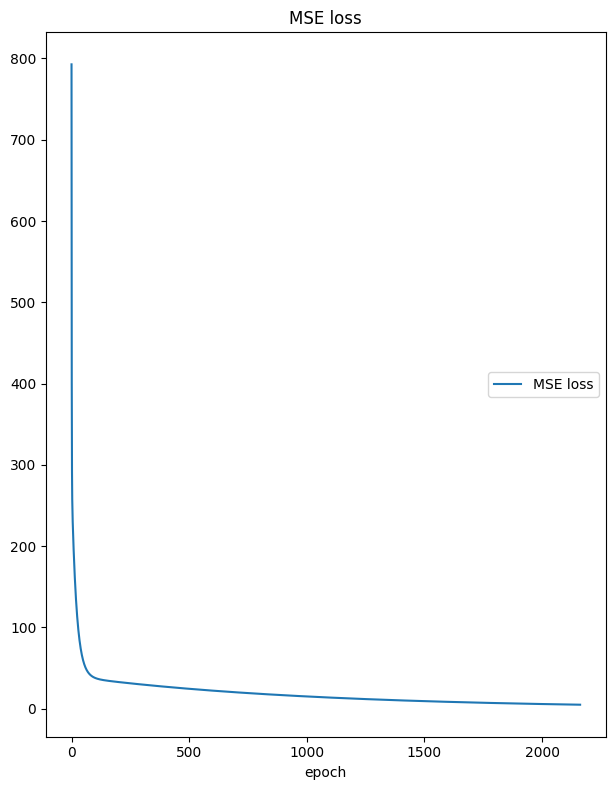

MSE loss
	MSE loss         	 (min:    4.816, max:  792.777, cur:    4.816)
Iteration: 216400
Gradient: [[ 1.160000e-02 -4.353000e-01  3.767700e+00 -1.140470e+01  1.117495e+02]]
Weights: [[-4.7631  1.1078 -2.2278  0.7663  0.0229]]
MSE loss: 4.8157


KeyboardInterrupt: 

In [38]:
liveloss = PlotLosses()
max_iterations = 1000000
lr = [1e-4, 1e-5, 1e-6, 1e-7, 1e-9]
K = len(lr)

tol = 1e-3
#batch_size = int(0.6 * points) # 60%
# Weights.
w_coeff = np.zeros((1,K))
w_grad = np.ones_like(w_coeff)
w_coeff_lr = w_coeff.copy()
losses = []
loss = 2 * tol
i = 0
while loss > tol:
    i += 1
#for i in range(max_iterations):
    for idx, w in enumerate(w_coeff.tolist()[0]):
        w_coeff_u = w_coeff.copy()
        w_step = - lr[idx] * w_grad[0,idx]
        w_coeff_u[0,idx] = w + w_step
        w_coeff_lr[0,idx] = w_coeff_u[0,idx]
        #batch_indices = np.random.choice(len(X_train), size=batch_size, replace=True)

        # Выборка элементов по индексам
        #X_train_batch = [X_train[k] for k in batch_indices]
        #y_train_batch = [y_train[k] for k in batch_indices]
        #w_grad[0,idx] = np.gradient([loss_func(X_train_batch, y_train_batch, w_coeff), loss_func(X_train_batch, y_train_batch, w_coeff_u)], w_step)[0]
        loss = loss_func(X_train, y_train, w_coeff)
        w_grad[0,idx] = np.gradient([loss, loss_func(X_train, y_train, w_coeff_u)], w_step)[0]
    w_coeff = w_coeff_lr.copy()
    
    
    losses.append(loss)
    
    if i % 100 == 0:
        if loss < 1000:
            liveloss.update({'MSE loss': loss})
            liveloss.draw()
        print('Iteration:', i)
        print('Gradient:', np.round(w_grad,4))
        print('Weights:', np.round(w_coeff,4))
        print('MSE loss:', np.round(loss,4))
            
    #if loss < tol:
    #    print('Tolerance riched!')
    #    break


f1(x)=x^3−3x^2+2x−5

f2(x)=w3.x^3 + w2.x^2 + w1.x + w0

где ожидаемые значения весов:

w0 = -5

w1 = 2

w2 = -3

w3 = 1